In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns 
%matplotlib inline
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [ ]:
from google.colab import files
files.upload()

In [ ]:
df = pd.read_csv('Irish_Solar.csv',parse_dates=['Date'], index_col='Date',encoding= 'unicode_escape')
df.head()

,Temperature (°C),Radiation_direct_horizontal(W/m²),Radiation_diffuse_horizontal(W/m²),Sun Duration,Relative_humidity
Date,,,,,
2017-01-01 00:00:00,4.739,0.0,0.0,0.0,91
2017-01-01 01:00:00,4.416,0.0,0.0,0.0,95
2017-01-01 02:00:00,4.017,0.0,0.0,0.0,92
2017-01-01 03:00:00,3.597,0.0,0.0,0.0,90
2017-01-01 04:00:00,3.275,0.0,0.0,0.0,88


In [ ]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

In [ ]:
df.columns=['T(°C)','R_dir_h','R_diff_h','Sun_Dur','Rel_hum','h','dom','dow','m']

In [ ]:
df.head()

,T(°C),R_dir_h,R_diff_h,Sun_Dur,Rel_hum,h,dom,dow,m
Date,,,,,,,,,
2017-01-01 00:00:00,4.739,0.0,0.0,0.0,91,0,1,6,1
2017-01-01 01:00:00,4.416,0.0,0.0,0.0,95,1,1,6,1
2017-01-01 02:00:00,4.017,0.0,0.0,0.0,92,2,1,6,1
2017-01-01 03:00:00,3.597,0.0,0.0,0.0,90,3,1,6,1
2017-01-01 04:00:00,3.275,0.0,0.0,0.0,88,4,1,6,1


In [ ]:
X = df[['T(°C)','R_diff_h','Sun_Dur','Rel_hum','h','dom','dow','m']]
y = df['R_dir_h']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
regressor = RandomForestRegressor(n_estimators = 100)
regressor.fit(X_train, y_train)
feature_importances = regressor.feature_importances_

X_train_opt = X_train.copy()
removed_columns = pd.DataFrame()
models = []
r2s_opt = []

for i in range(0,6):
    least_important = np.argmin(feature_importances)
    removed_columns = removed_columns.append(X_train_opt.pop(X_train_opt.columns[least_important]))
    regressor.fit(X_train_opt, y_train)
    feature_importances = regressor.feature_importances_
    accuracies = cross_val_score(estimator = regressor,
                                 X = X_train_opt,
                                 y = y_train, cv = 6,
                                 scoring = 'r2')
    r2s_opt = np.append(r2s_opt, accuracies.mean())
    models = np.append(models, ", ".join(list(X_train_opt)))
    
feature_selection = pd.DataFrame({'Features':models,'r2 Score':r2s_opt})
feature_selection.head(6)

,Features,r2 Score
0,"T(°C), R_diff_h, Sun_Dur, Rel_hum, h, dom, m",0.883655
1,"T(°C), R_diff_h, Sun_Dur, Rel_hum, h, dom",0.857734
2,"T(°C), R_diff_h, Sun_Dur, Rel_hum, h",0.821480
3,"T(°C), R_diff_h, Rel_hum, h",0.792783
4,"T(°C), R_diff_h, Rel_hum",0.549650
5,"T(°C), R_diff_h",0.442226


In [ ]:
X_train_best = X_train[['T(°C)', 'R_diff_h', 'Rel_hum', 'Sun_Dur','h']]
X_test_best = X_test[['T(°C)', 'R_diff_h', 'Rel_hum','Sun_Dur', 'h']]
regressor.fit(X_train_best, y_train)

RandomForestRegressor()

In [ ]:
accuracies = cross_val_score(estimator = regressor, X = X_train_best,y = y_train, cv = 10, scoring = 'r2')
accuracy = accuracies.mean()
print('r2 = {}'.format(accuracy))

r2 = 0.8200109305234152


In [ ]:
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
y_pred = regressor.predict(X_test_best)
explained_variance_score = explained_variance_score(y_test, y_pred)
mean_squared_error = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
print('explained variance = {}'.format(explained_variance_score))
print('mse = {}'.format(mean_squared_error))
print('r2 = {}'.format(r_squared))

explained variance = 0.8370785760290684
mse = 3194.455939932463
r2 = 0.8370694547369921


In [ ]:
# Predicting for whole dataset
df['y_pred'] = regressor.predict(df[['T(°C)', 'R_diff_h', 'Rel_hum', 'Sun_Dur','h']])

# Create Interactive Plot Using Bokeh
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Range1d
output_notebook() 
#df['Date']=pd.to_datetime(df['Date'])
p = figure(plot_width=800, 
           plot_height=400,
           title="Solar Irradiance Predictions",
           x_axis_label='Date and Time',
           y_axis_label='Radiation_direct_horizontal(W/m²)',
           x_axis_type="datetime")
p.x_range = Range1d(df.index[0], df.index[600])
p.y_range = Range1d(-100, 1800, bounds=(-100, 1800))
p.line(df.index, df['R_dir_h'], legend_label='Observed Solar Irradiance', line_width=1)
p.line(df.index, df['y_pred'], legend_label='Predicted Solar Irradiance', line_width=1, line_color="red")
show(p, notebook_handle = True)

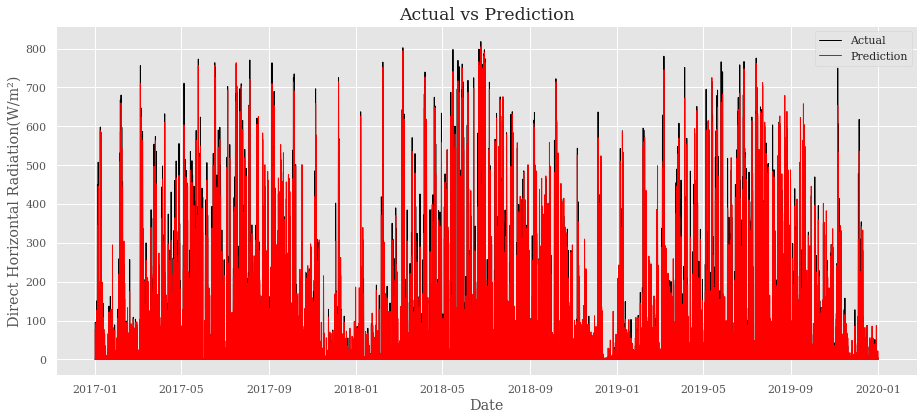

In [ ]:
df['Date'] = df.index
import datetime
import matplotlib.style as style 
sns.set(font_scale = 1)
style.use('ggplot')

palette=("Blues_d")
plt.style.use('ggplot')
plt.rcParams['font.family'] = "serif"
plt.rcParams.update({'font.size': 12})
#rcParams['figure.figsize'] = 13, 6

sns.lineplot(x=df.index, y='R_dir_h' ,data=df,linestyle='-',color='black',linewidth =1,label='Actual')
sns.lineplot(x=df.index, y='y_pred' ,data=df,linestyle='-',color='red',linewidth =1,label='Prediction')
plt.title('Actual vs Prediction')
plt.ylabel('Direct Horizontal Radiation(W/m²)')
#plt.xlim([datetime.date(2019, 7, 10), datetime.date(2019, 7, 20)])
rcParams.update({'figure.autolayout': True})
plt.savefig('irishsolar1.pdf')

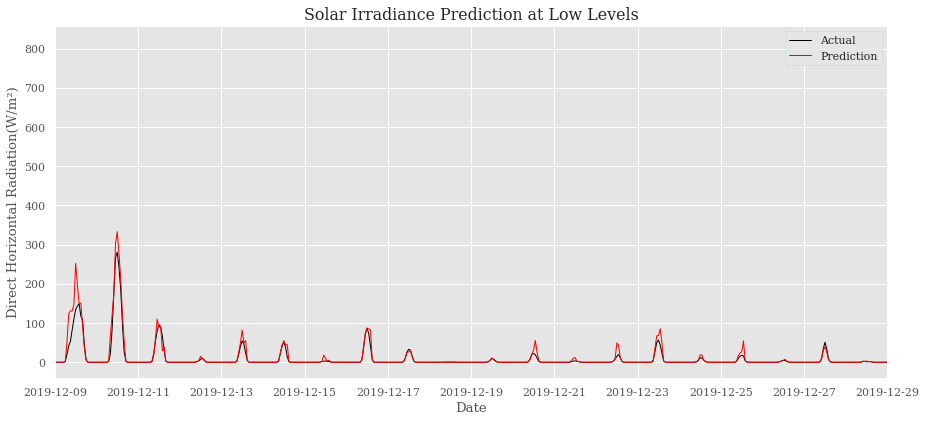

In [ ]:
rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 11})
sns.lineplot(x=df.index, y='R_dir_h' ,data=df,linestyle='-',color='black',linewidth =1,label='Actual')
sns.lineplot(x=df.index, y='y_pred' ,data=df,linestyle='-',color='red',linewidth =1,label='Prediction')

plt.ylabel('Direct Horizontal Radiation(W/m²)')
plt.title('Solar Irradiance Prediction at Low Levels')

plt.xlim([datetime.date(2019, 12, 9), datetime.date(2019,12, 29)])
plt.rcParams['font.family'] = "serif"
plt.savefig('irishsolar2.pdf')

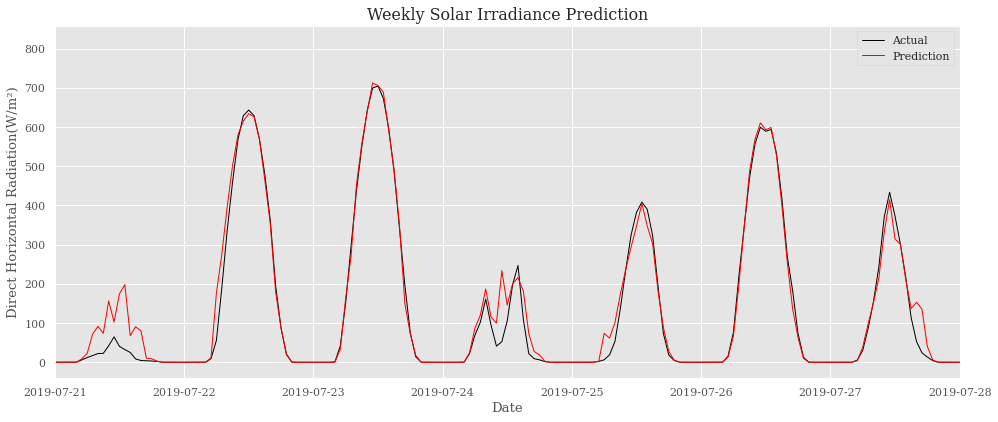

In [ ]:
rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 11})
sns.lineplot(x=df.index, y='R_dir_h' ,data=df,linestyle='-',color='black',linewidth =1,label='Actual')
sns.lineplot(x=df.index, y='y_pred' ,data=df,linestyle='-',color='red',linewidth =1,label='Prediction')

plt.ylabel('Direct Horizontal Radiation(W/m²)')
plt.title('Weekly Solar Irradiance Prediction')

plt.xlim([datetime.date(2019, 7, 21), datetime.date(2019,7,28)])
plt.rcParams['font.family'] = "serif"
rcParams['figure.figsize'] = 14, 6
plt.savefig('irishsolarweek.pdf')